# Result of time-domain inference on GW200208_222617

In [1]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np 
import h5ify, h5py
import bilby
from scipy.stats import norm, gaussian_kde
import shutil
from tqdm import tqdm
import lal
import json

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.lines import Line2D
import seaborn as sns
cmap1 = sns.color_palette('colorblind')
cmap2 = sns.color_palette('dark')

import sys, os
sys.path.append('/home/simona.miller/time-domain-gw-inference')
from time_domain_gw_inference import group_postprocess, utils, run_sampler, waveform_h5s

### Load in result
Load in the time-domain inference result using the functionality of `group_postprocess`.

In [2]:
def load_TD_results(run): 

    # Load in the result
    result = group_postprocess.load_run_settings_from_directory(
        'output/'+run,
        filename_dict={'full':'full_0.0seconds'}
    )
    
    # Likelihood manager 
    lm = result['runs']['full']['likelihood_manager']  
    
    # Extract the posterior
    posterior = result['dfs']['full']

    # To match bilby convention
    posterior['polarization'] = posterior['polarization'] % np.pi

    # Needed for prior reweighting later
    posterior['chirp_mass'] = utils.get_chirpmass(posterior['mass1'], posterior['mass2'])

    return posterior, result, lm 

run = '250725_output'
TD_posterior, TD_result, lm = load_TD_results(run)

warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
alert! dynamic range of PSD is 50 orders of magnitude!
alert! dynamic range of PSD is 50 orders of magnitude!
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
alert! dynamic range of PSD is 50 orders of magnitude!
alert! dynamic range of PSD is 50 orders of magnitude!
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
alert! dynamic range of PSD is 50 orders of magnitude!
alert! dynamic range of PSD is 50 orders of magnitude!


Load in the `bilby` result for comparison.

In [3]:
# Load in the result
FD_result = h5ify.load(
    os.path.join('output/'+run, TD_result['runs']['full']['args'].pe_posterior_h5_file)
)
# Extract the posterior
FD_posterior = FD_result['C01:IMRPhenomXPHM']['posterior_samples']

### Prior reweighting
The two runs differ in the priors for masses, luminosity distance, and time. First, make a bilby prior object with some useful priors:

In [4]:
# Extract prior
from bilby.core.prior import PriorDict, PowerLaw, Uniform
from bilby.gw.prior import UniformInComponentsChirpMass

_bilby_prior = FD_result['C01:IMRPhenomXPHM']['priors']['analytic']

bilby_prior = bilby.core.prior.PriorDict()
bilby_prior['luminosity_distance'] = eval(_bilby_prior['luminosity_distance'][0].decode(encoding='utf-8'))
bilby_prior['chirp_mass'] = eval(_bilby_prior['chirp_mass'][0].decode(encoding='utf-8'))
bilby_prior['geocent_time'] = eval(_bilby_prior['geocent_time'][0].decode(encoding='utf-8'))

print(bilby_prior)

{'luminosity_distance': PowerLaw(alpha=2, minimum=100, maximum=20000, name='luminosity_distance', latex_label='$d_L$', unit='Mpc', boundary=None), 'chirp_mass': bilby.gw.prior.UniformInComponentsChirpMass(minimum=11.504447914091882, maximum=143.4519065811048, name='chirp_mass', latex_label='$\\mathcal{M}$', unit='$M_{\\odot}$', boundary=None), 'geocent_time': Uniform(minimum=1265235995.9045322, maximum=1265235996.104532, name='geocent_time', latex_label='$t_c$', unit='$s$', boundary=None)}


In [31]:
# Jacobian between uniform in (M,q) <--> uniform in (m1,m2)
def get_jacobian(m1, m2):
    return m1**2/(m1+m2)

# Calculate bilby prior weights on the TD samples for parameters of interest (masses, distance)
p_bilby_masses = get_jacobian(TD_posterior['mass1'], TD_posterior['mass2'])
p_bilby_DL =  bilby_prior['luminosity_distance'].prob(TD_posterior['luminosity_distance'])
p_bilby = p_bilby_masses * p_bilby_DL

# Calculate TD prior on the TD samples for parameters of interest (geocenter time) 
p_TD = norm.pdf(TD_posterior['geocenter_time'], loc=lm.reference_time, scale=lm.sigma_time)

# Reweight
weights = p_bilby / p_TD

# Hard cut on chirp mass
td_mask_M = (TD_posterior['chirp_mass'] > bilby_prior['chirp_mass'].minimum) & (TD_posterior['chirp_mass'] < bilby_prior['chirp_mass'].maximum) 
weights[~td_mask_M] = 0

# Hard cut on geocenter time 
#td_mask_t = (TD_posterior['geocenter_time'] > bilby_prior['geocent_time'].minimum) & (TD_posterior['geocenter_time'] < bilby_prior['geocent_time'].maximum)
#td_mask_t = (TD_posterior['geocenter_time'] > min(FD_posterior['geocent_time'])) & (TD_posterior['geocenter_time'] < max(FD_posterior['geocent_time'])) 
td_mask_t = (TD_posterior['geocenter_time'] > lm.reference_time - 2*lm.sigma_time) & (TD_posterior['geocenter_time'] < lm.reference_time + 2*lm.sigma_time) 
weights[~td_mask_t] = 0

# Hard cut on total mass 
weights[TD_posterior['total_mass'] > 400] = 0

In [32]:
# Calculate the effective number of samples
from scipy.special import logsumexp
logwts = np.log(weights)
logneff = logsumexp(logwts) * 2 - logsumexp(logwts * 2)
neff = np.exp(logneff)

print('total samples:', len(weights))
print('effective samples:', neff)

total samples: 6144
effective samples: 1095.2703345969412


/mnt/home/smiller/src/time-domain-gw-inference/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Plot comparison

The two codes use different naming keys for the parameters, so we must set up a dictionary to translate between them:

In [33]:
# keys = bilby keys; values = TD keys
key_transform = {
    'mass_ratio':'mass_ratio', 
    'total_mass':'total_mass',
    'mass_1':'mass1',
    'mass_2':'mass2',
    'luminosity_distance':'luminosity_distance',
    'a_1':'spin1_magnitude',
    'a_2':'spin2_magnitude',
    'tilt_1':'tilt1',
    'tilt_2':'tilt2',
    'phi_12':'phi12',
    'phi_jl':'phi_jl',
    'theta_jn':'theta_jn',
    'ra':'right_ascension', 
    'dec':'declination',
    'psi':'polarization',
    'phase':'phase',
    'geocent_time':'geocenter_time'
}

In [37]:
# make empty dict
JSD_dict = {}

# we care about masses and spins; there are slightly different naming conventions 
# between the two codes
param_names = ['total_mass', 'mass_ratio', 'mass1', 'mass2', 
               'chi_effective', 'chi_precessing', 'spin1_magnitude', 'spin2_magnitude'] 
param_names_bilby = ['total_mass', 'mass_ratio', 'mass_1', 'mass_2', 
                     'chi_eff', 'chi_p', 'a_1', 'a_2'] 

# cycle through parameters
for pb,p in key_transform.items():

    # calculate JSD
    JSD = utils.calculate_js(
        samplesA=FD_posterior[pb], 
        samplesB=TD_posterior[p],
        ntests=100, 
        nsamples=int(neff)
    )

    JSD_rw = utils.calculate_js(
        samplesA=FD_posterior[pb], 
        samplesB=TD_posterior[p],
        weightsB=weights/np.sum(weights),
        ntests=100, 
        nsamples=int(neff)
    )

    # print its information
    JSD_str = f"JSD: {JSD.median * 1e3:0.1f}+{JSD.plus * 1e3:0.1f}-{JSD.minus * 1e3:0.1f} mb"
    print(pb, JSD_str)

    # add to dict
    JSD_dict[pb] = {'td prior':JSD.median, 'fd prior':JSD_rw.median}

mass_ratio JSD: 62.4+8.6-7.7 mb
total_mass JSD: 52.4+6.1-5.0 mb
mass_1 JSD: 80.5+6.7-6.1 mb
mass_2 JSD: 52.2+8.1-6.2 mb
luminosity_distance JSD: 21.9+4.7-3.8 mb
a_1 JSD: 42.1+5.1-6.6 mb
a_2 JSD: 0.8+0.5-0.4 mb
tilt_1 JSD: 41.5+4.9-4.8 mb
tilt_2 JSD: 2.5+1.3-0.9 mb
phi_12 JSD: 0.7+0.6-0.4 mb
phi_jl JSD: 1.0+0.5-0.5 mb
theta_jn JSD: 0.8+0.6-0.3 mb
ra JSD: 12.7+4.3-2.7 mb
dec JSD: 11.6+3.8-2.4 mb
psi JSD: 2.0+1.2-0.9 mb
phase JSD: 5.1+1.5-1.7 mb
geocent_time JSD: 10.8+1.9-1.5 mb


Generate comparison plot for the two posteriors

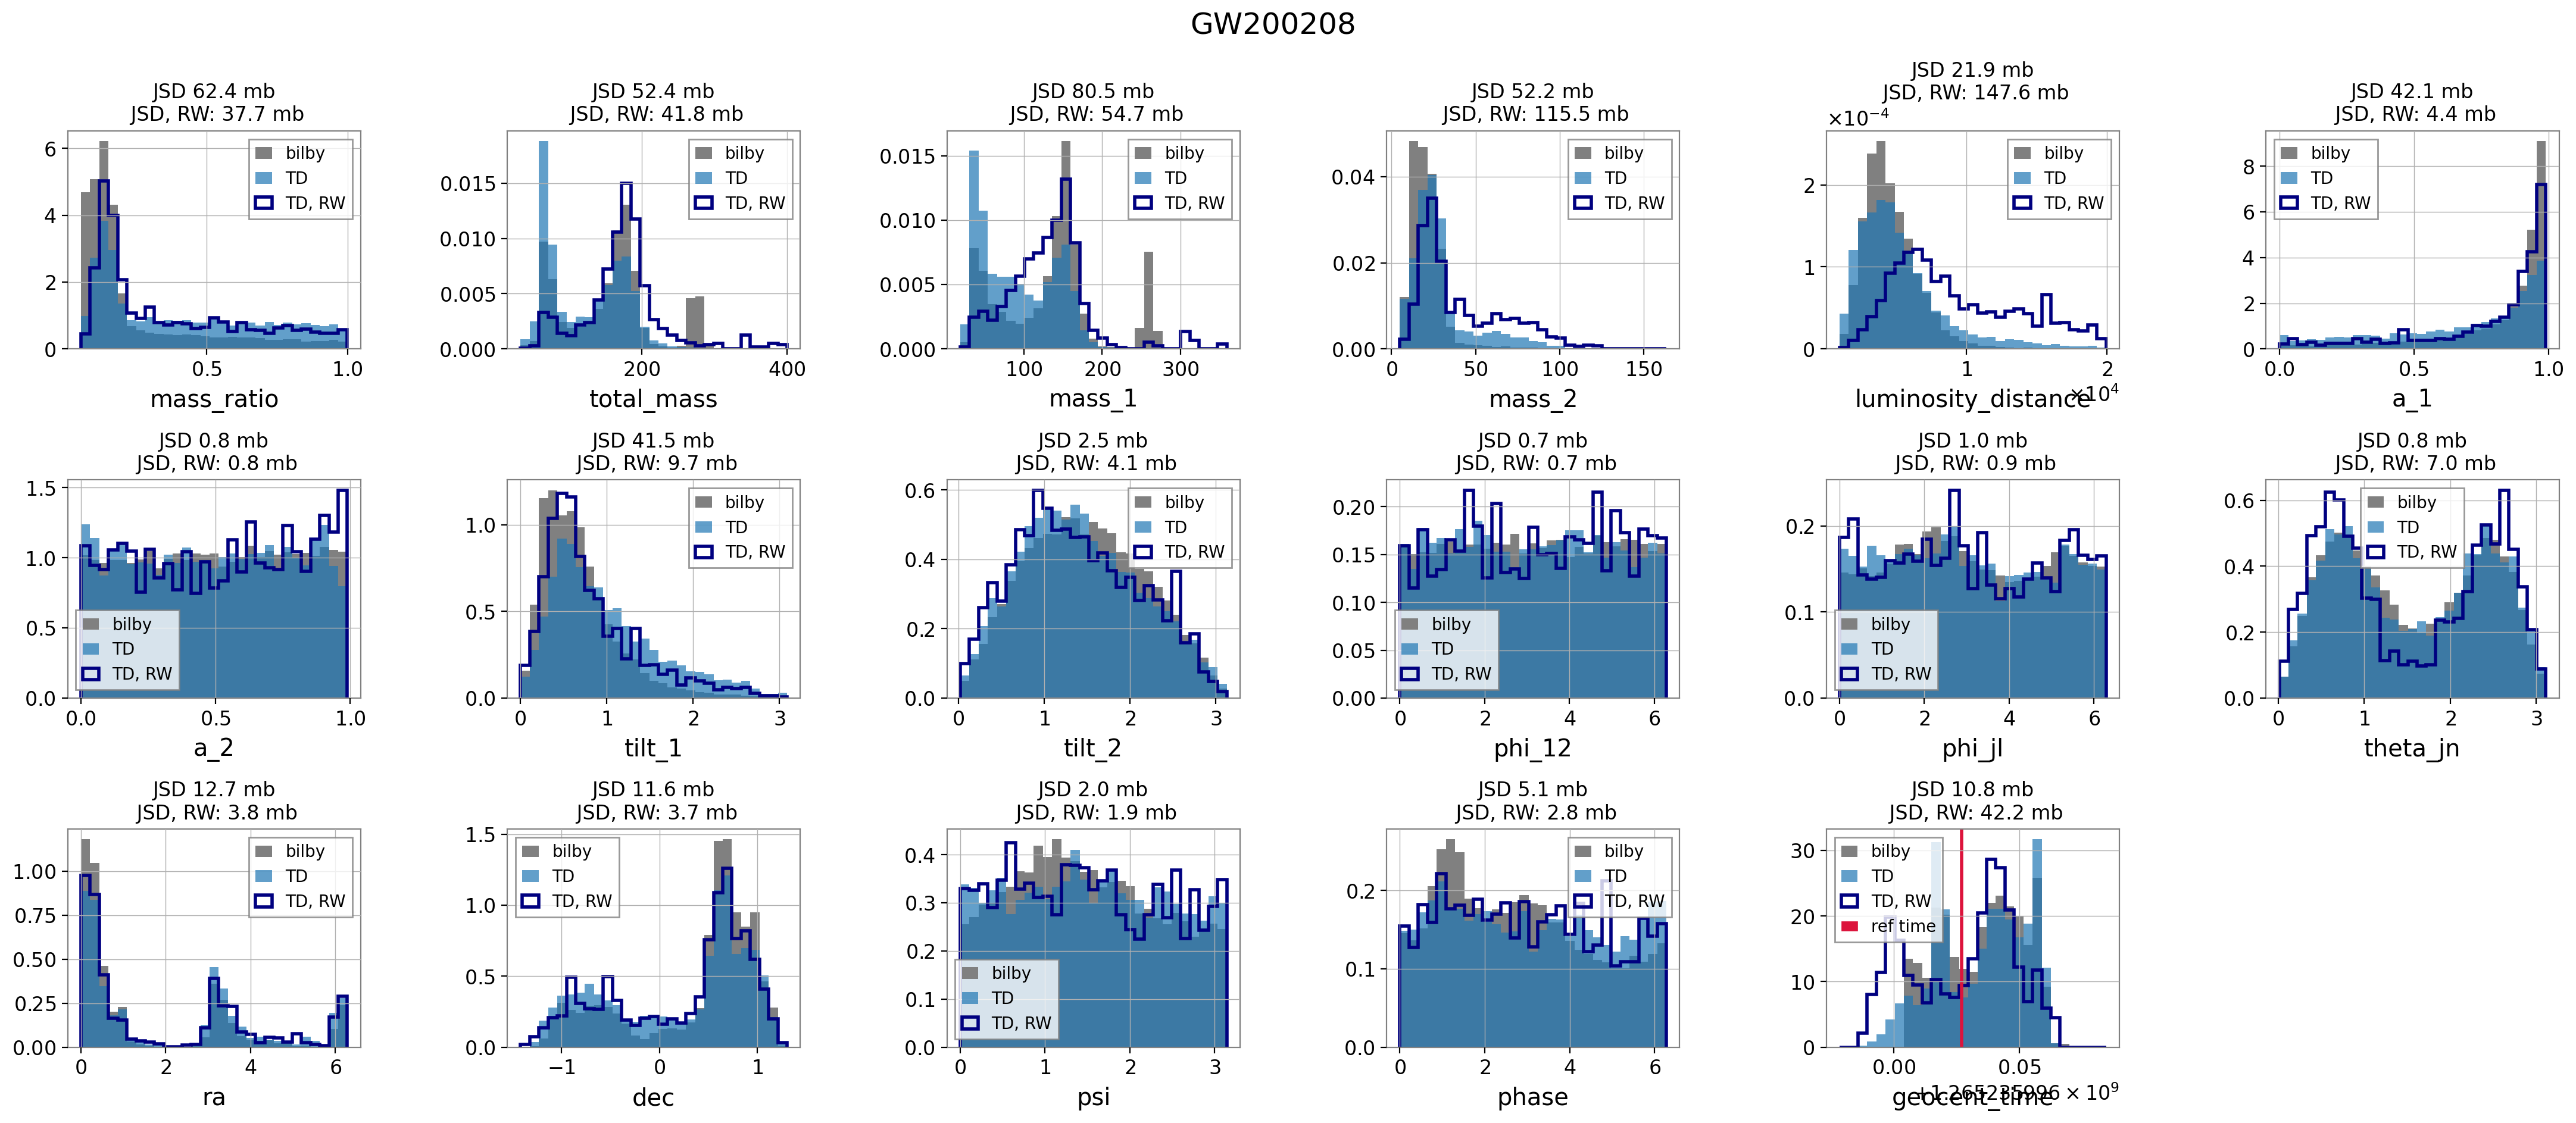

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(27,10))

for k, ax in zip(key_transform.keys(), axes.flatten()): 


    TD_samps = TD_posterior[key_transform[k]]
    FD_samps = FD_posterior[k]
    
    hist_kws = dict(density=True, bins=np.linspace(min(TD_samps), max(TD_samps), 30))
    
    ax.hist(FD_samps, **hist_kws, color='gray',label='bilby')
    ax.hist(TD_samps, **hist_kws, color='C0', alpha=0.7, label='TD')
    ax.hist(TD_samps, **hist_kws, weights=weights, histtype='step', color='navy', lw=2, label='TD, RW')
    ax.set_xlabel(k)
    ax.legend(fontsize=10)

    JS = round(JSD_dict[k]['td prior']*1e3, 1)
    JS_rw = round(JSD_dict[k]['fd prior']*1e3, 1)
    ax.set_title('JSD '+str(JS)+' mb\n JSD, RW: '+str(JS_rw)+' mb', fontsize=12)
    
plt.subplots_adjust(hspace=0.6, wspace=0.5)
axes[-1][-1].set_visible(False)

axes[-1][-2].axvline(lm.reference_time, color='crimson', lw=2, label='ref time')
axes[-1][-2].legend(fontsize=10)

plt.suptitle('GW200208', fontsize=18)
plt.show()

## Some checks: 

First, check for convergence by plotting the run from which the final run was launched:

In [39]:
# run2 = 'xxx'
# TD_posterior2 = load_TD_results(run2)[0]

In [40]:
# fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(27,10))

# for k, ax in zip(key_transform.keys(), axes.flatten()): 

#     hist_kws = dict(density=True, bins=30)
#     ax.hist(TD_posterior2[key_transform[k]], **hist_kws, color='C1', alpha=0.7, label='run 1')
#     ax.hist(TD_posterior[key_transform[k]], **hist_kws, color='C0', alpha=0.7, label='run 2')
        
#     ax.set_xlabel(k)
#     ax.legend(fontsize=10)

# plt.subplots_adjust(hspace=0.5, wspace=0.5)
# axes[-1][-1].set_visible(False)
# plt.show()

And plot the MCMC chains themselves:

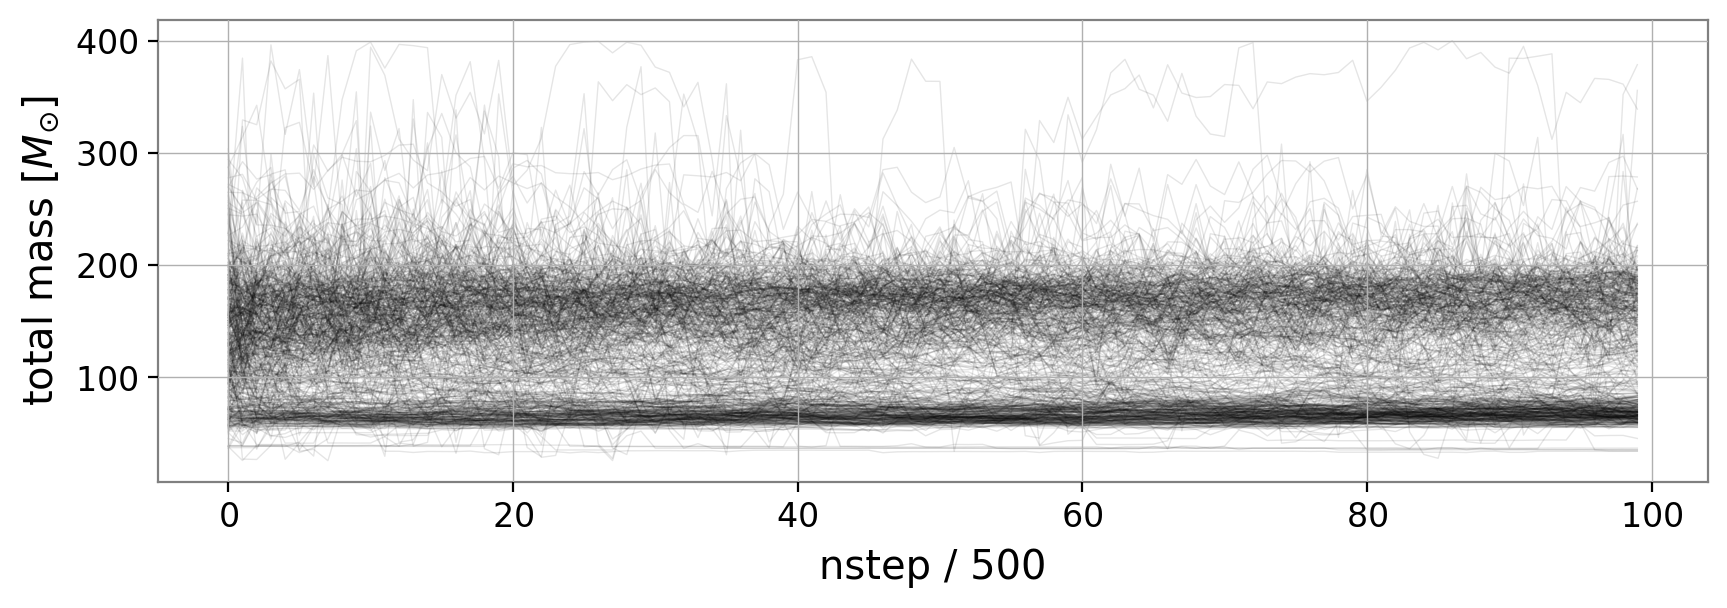

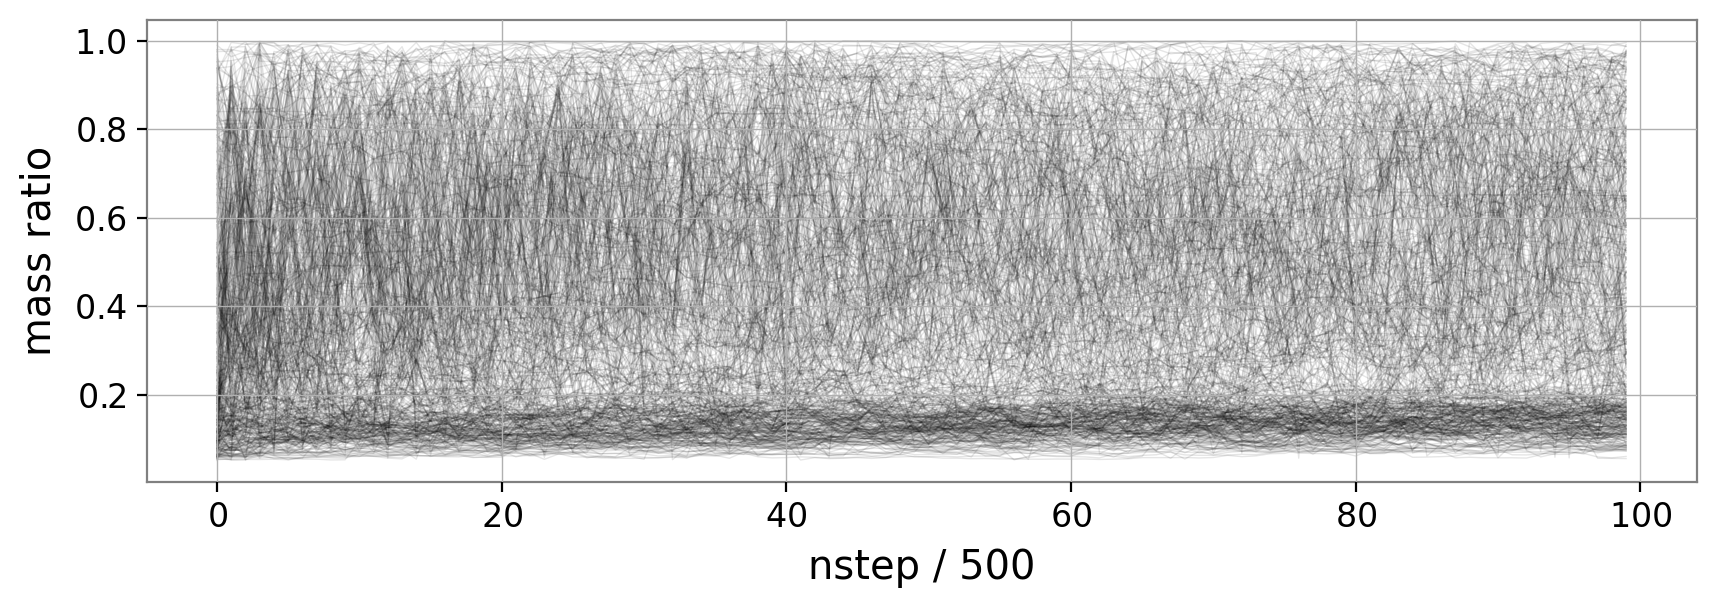

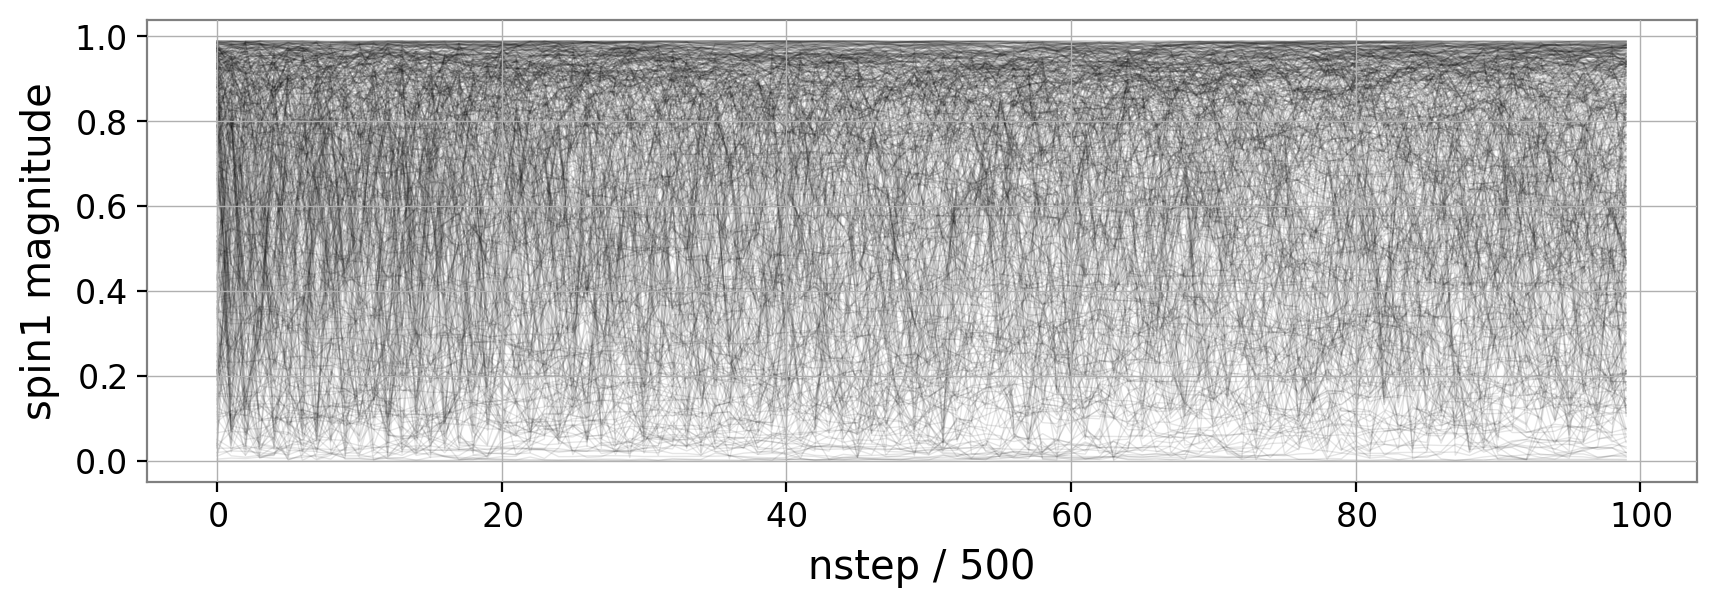

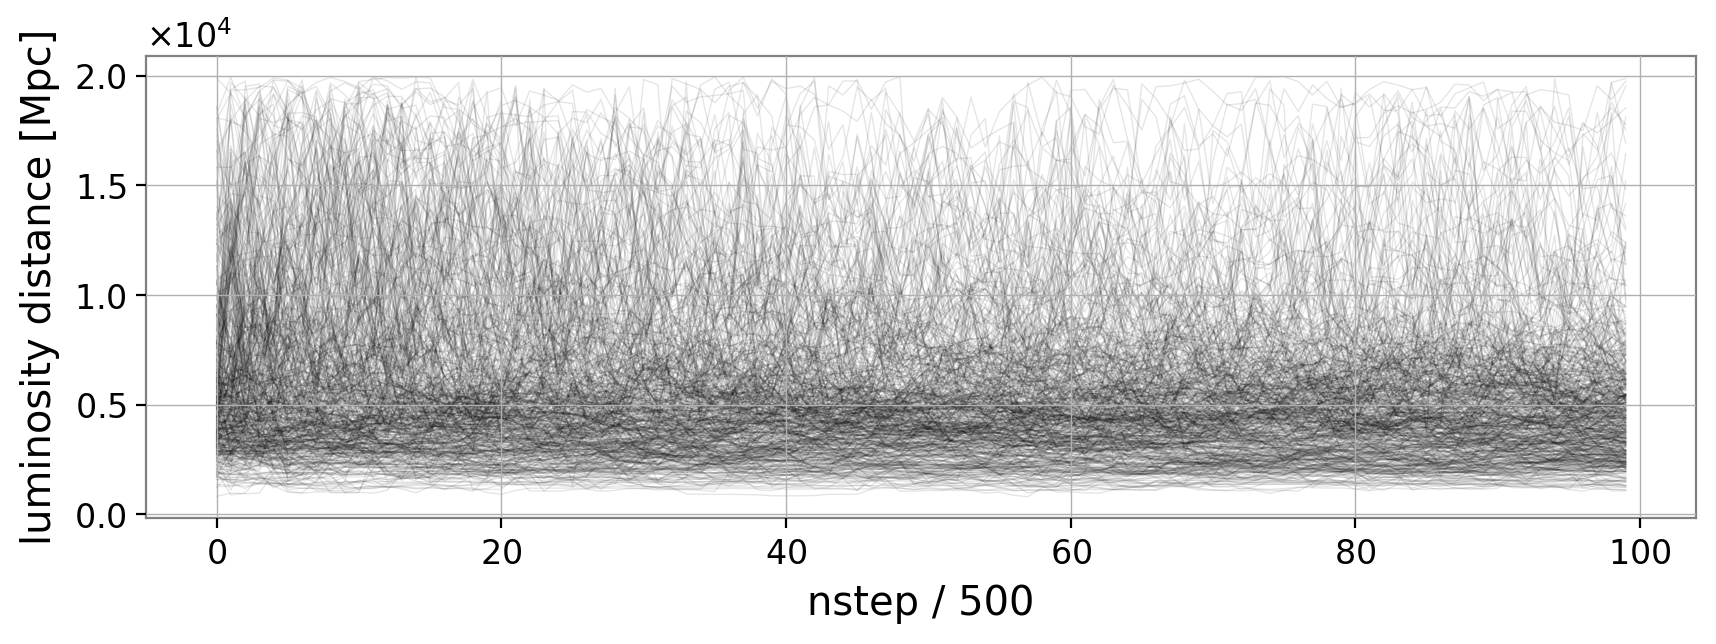

In [41]:
import emcee
f = f'output/{run}/full_0.0seconds/full_0.0seconds.h5'
backend = emcee.backends.HDFBackend(f, read_only=True) 

thin = 500
chain = backend.get_chain(thin=thin)

kwargs = TD_result['runs']['full']['kwargs']

# plot total mass chain
plt.figure(figsize=(10,3))
for ch in chain[:,:,lm.sampled_keys.index('x_total_mass')].T:
    ch_phys = utils.inv_logit(ch, *kwargs['mtot_lim'])
    plt.plot(ch_phys, color='k', lw=0.5, alpha=0.1)
plt.ylabel(r'total mass [$M_{\odot}$]')
plt.xlabel(f'nstep / {thin}');

# plot mass ratio chain
plt.figure(figsize=(10,3))
for ch in chain[:,:,lm.sampled_keys.index('x_mass_ratio')].T:
    ch_phys = utils.inv_logit(ch, *kwargs['q_lim'])
    plt.plot(ch_phys, color='k', lw=0.5, alpha=0.1)
plt.ylabel('mass ratio')
plt.xlabel(f'nstep / {thin}');

# plot primary spin chain
plt.figure(figsize=(10,3))
for ch in chain[:,:,lm.sampled_keys.index('x_spin1_magnitude')].T:
    ch_phys = utils.inv_logit(ch, *kwargs['chi_lim'])
    plt.plot(ch_phys, color='k', lw=0.5, alpha=0.1)
plt.ylabel('spin1 magnitude')
plt.xlabel(f'nstep / {thin}');

# plot luminosity distance
plt.figure(figsize=(10,3))
for ch in chain[:,:,lm.sampled_keys.index('x_luminosity_distance')].T:
    ch_phys = utils.inv_logit(ch, *kwargs['dist_lim'])
    plt.plot(ch_phys, color='k', lw=0.5, alpha=0.1)
plt.ylabel('luminosity distance [Mpc]')
plt.xlabel(f'nstep / {thin}');

### Plot waveforms

In [42]:
# Load
wfs = waveform_h5s.load_waveform_h5py(f'output/{run}/waveforms/full_waveforms.h5')
# Whiten 
wfs_whitened = utils.whiten_wfs(wfs['samples'], lm)

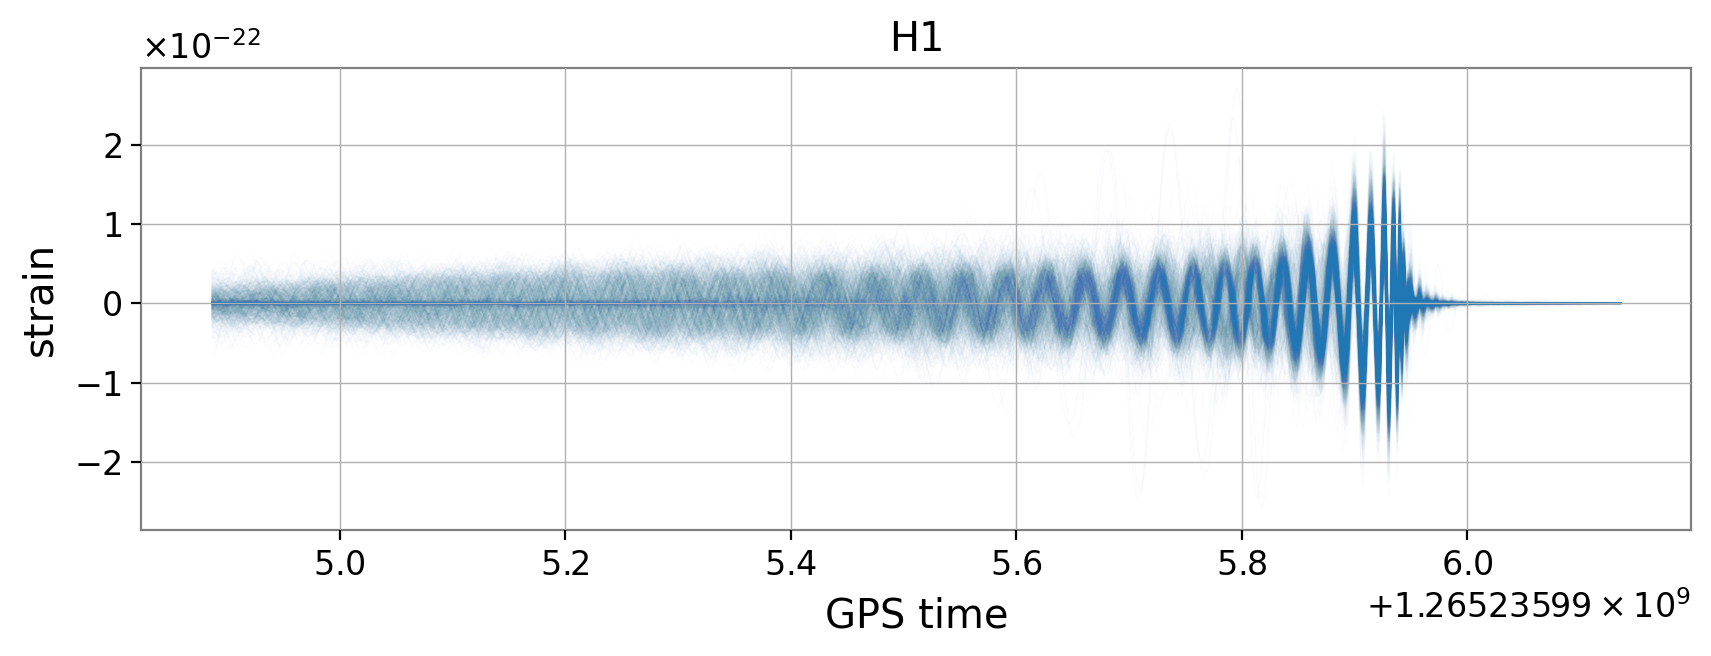

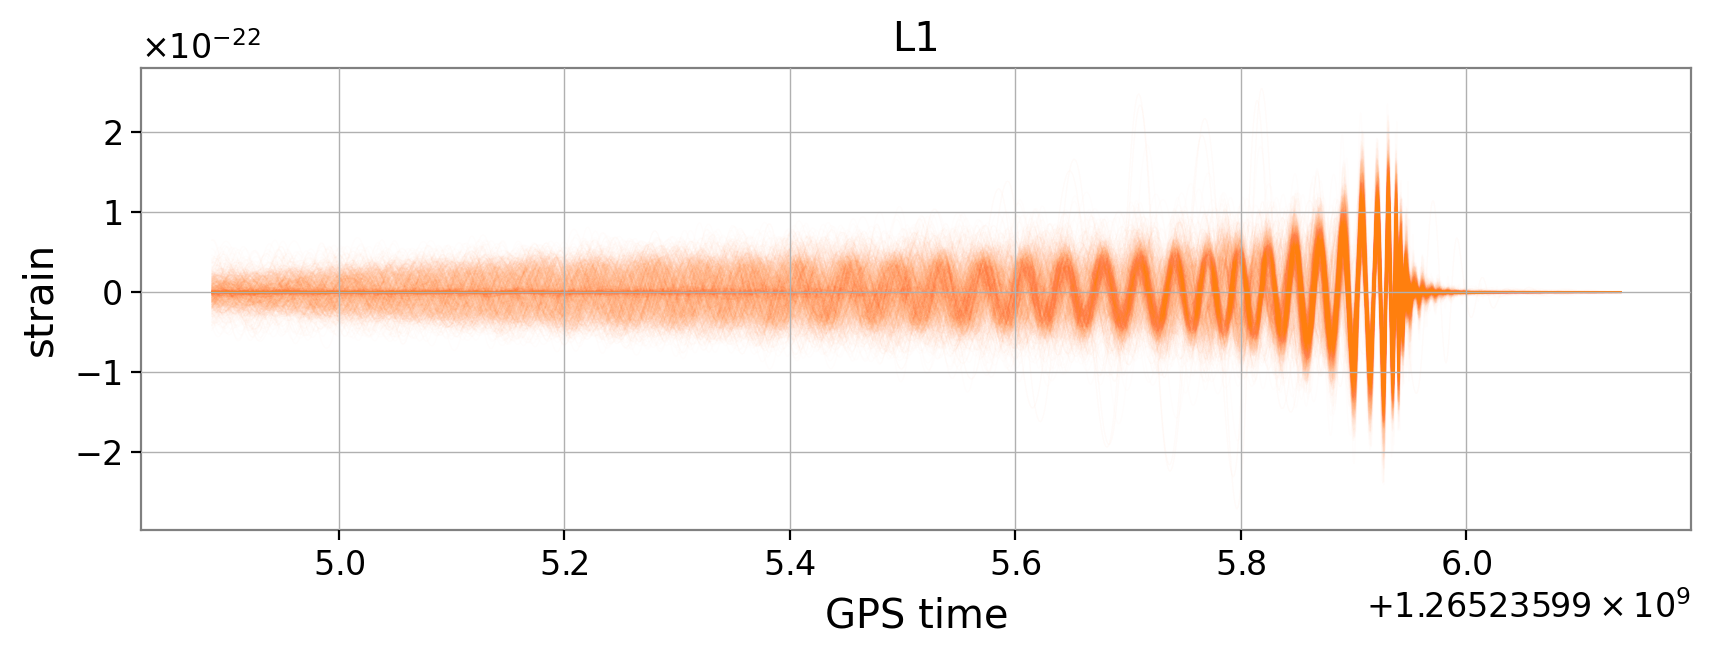

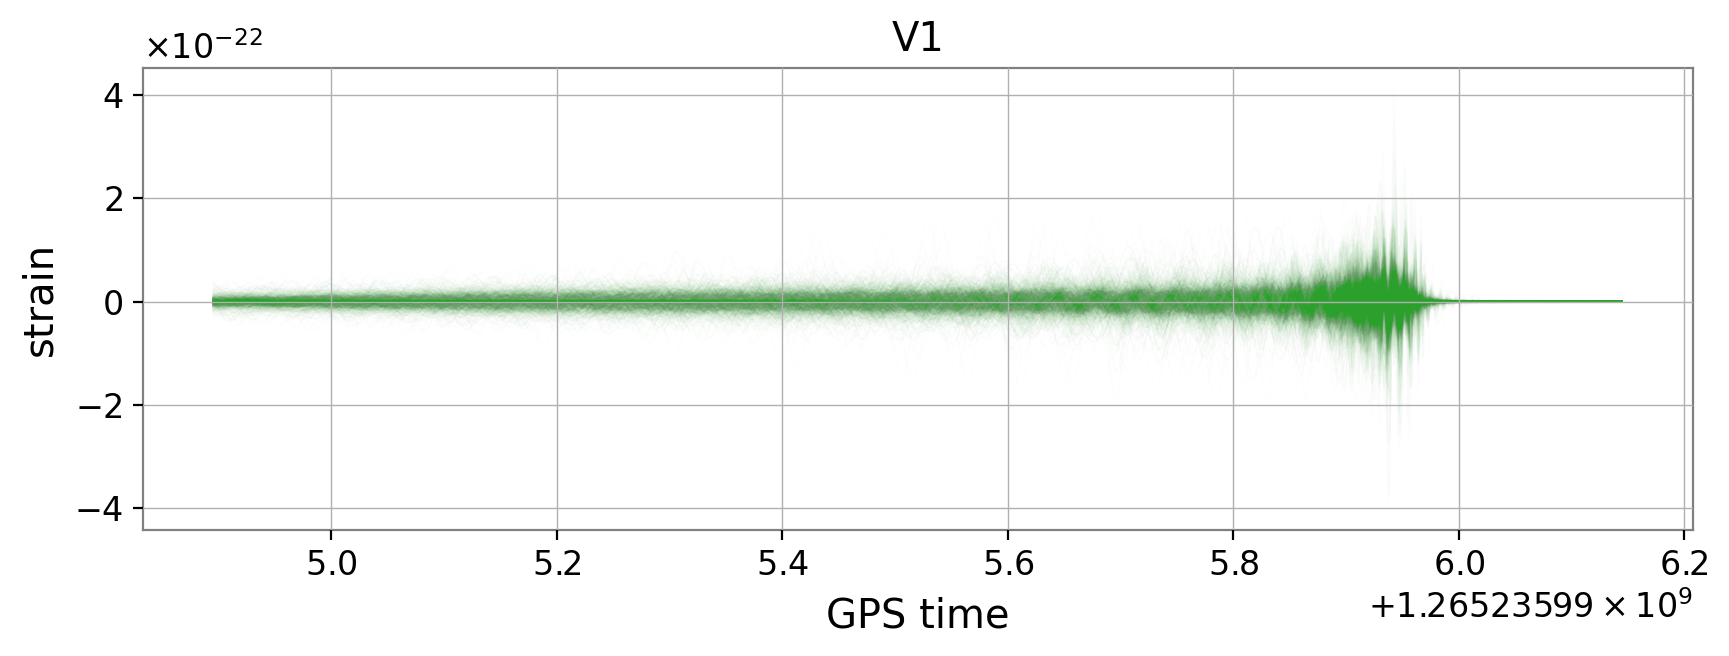

In [43]:
# Plot colored
for i, ifo in enumerate(lm.ifos): 

    plt.figure(figsize=(10, 3))
    
    # full
    for j in range(len(wfs['samples'])):
        plt.plot(lm.time_dict[ifo], wfs['samples'][j][ifo], color=f'C{i}', lw=0.5, alpha=0.01)
        
    plt.title(ifo)
    plt.xlabel('GPS time')
    plt.ylabel('strain')
    plt.show()

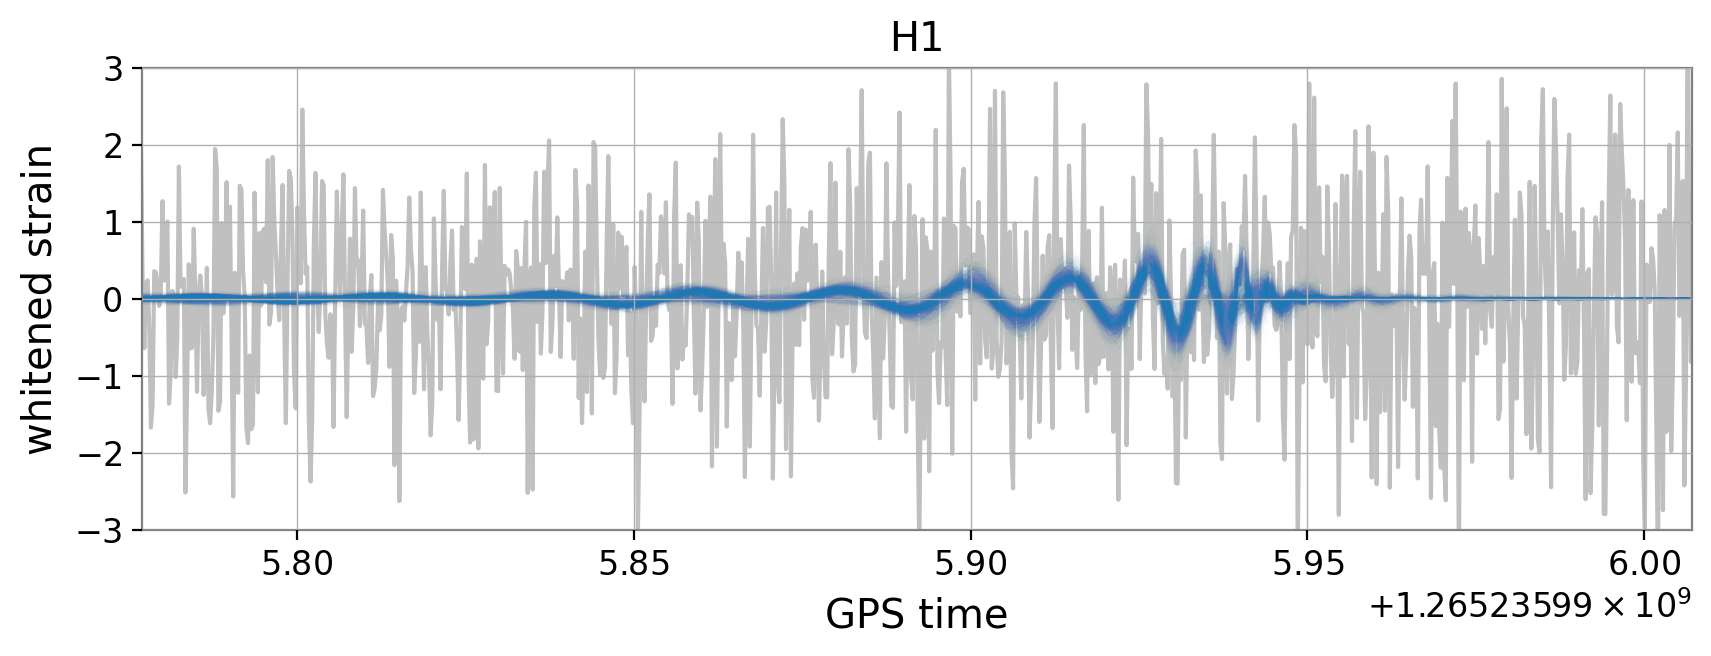

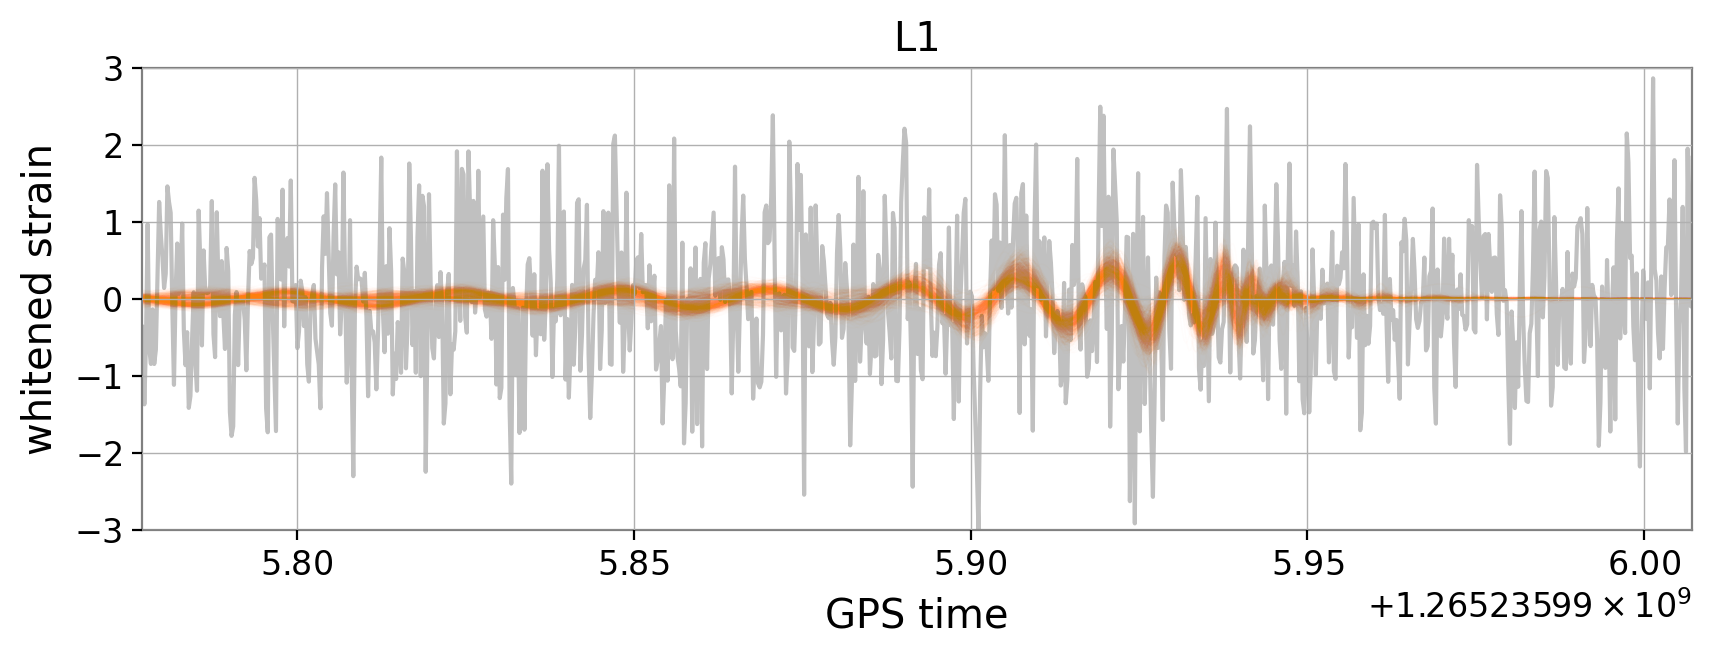

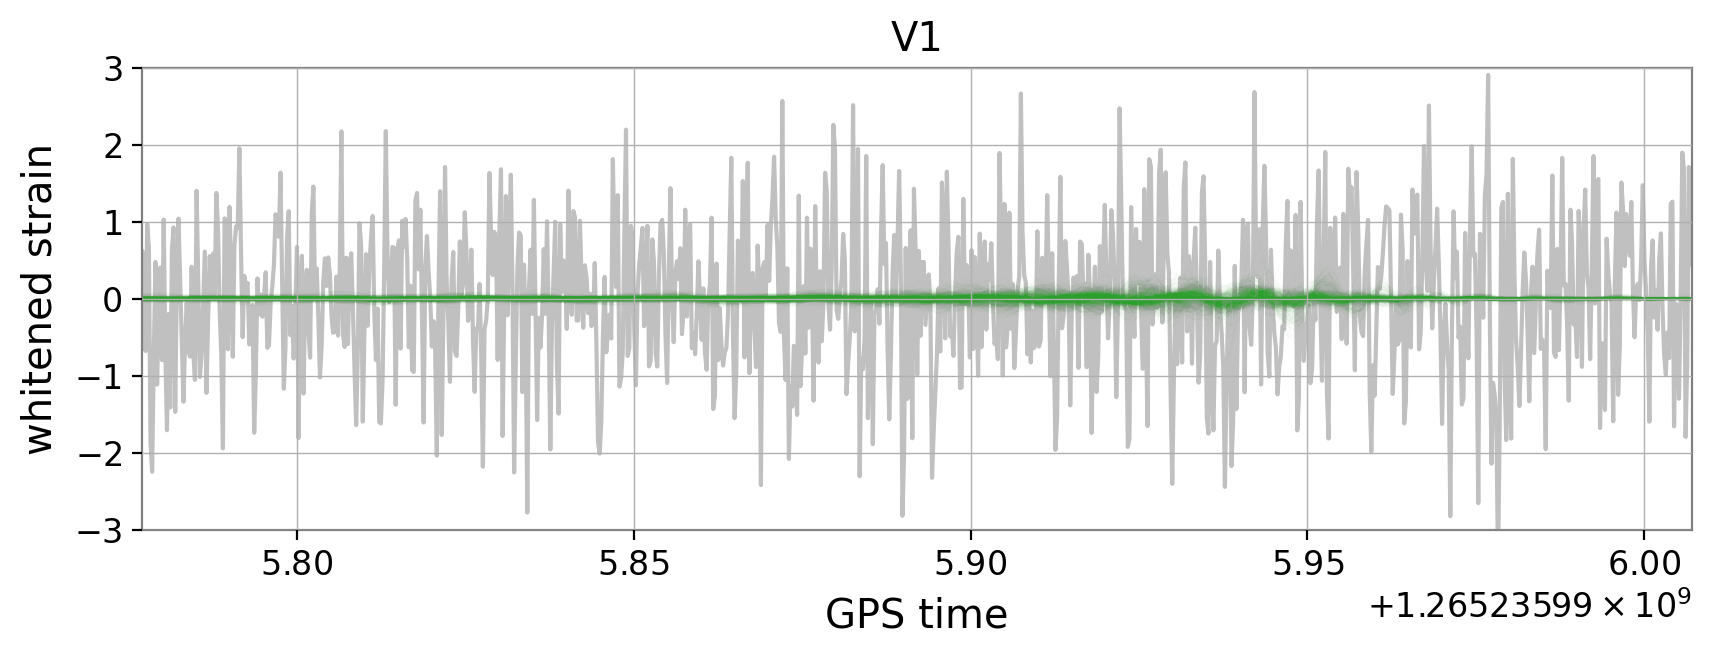

In [44]:
# Plot whitened (zoomed in around merger)
for i, ifo in enumerate(lm.ifos): 

    plt.figure(figsize=(10, 3))
    plt.plot(lm.time_dict[ifo], lm.whitened_data_dict[ifo], color='silver', zorder=0)

    # full
    for j in range(len(wfs_whitened)):
        plt.plot(lm.time_dict[ifo], wfs_whitened[j][ifo], color=f'C{i}', lw=0.5, alpha=0.01)
        
    plt.title(ifo)
    plt.xlim(lm.reference_time-0.15, lm.reference_time+0.08)
    plt.ylim(-3,3)
    plt.xlabel('GPS time')
    plt.ylabel('whitened strain')
    plt.show()

Are the residuals gaussian?

In [45]:
# Gaussian distribution
mean = 0 
std_dev = 1
x_values = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 500)
pdf_values = norm.pdf(x_values, loc=mean, scale=std_dev)

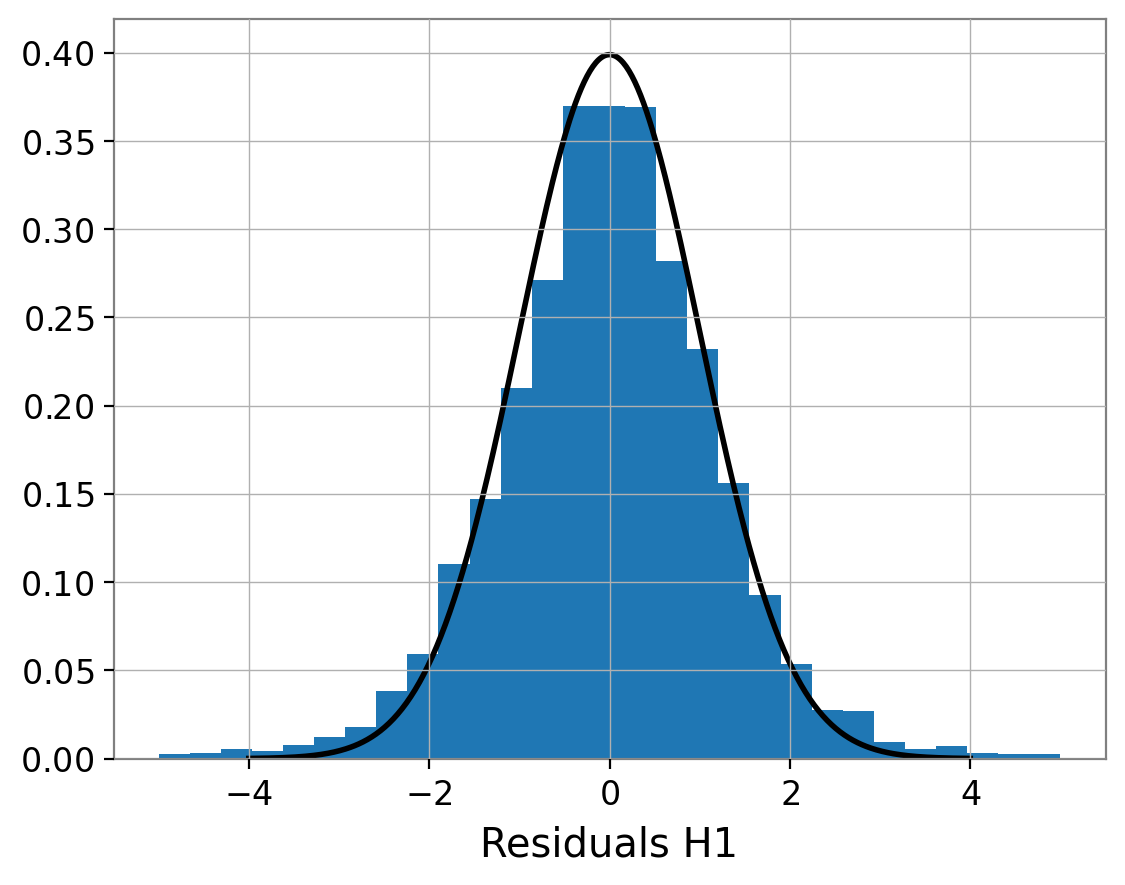

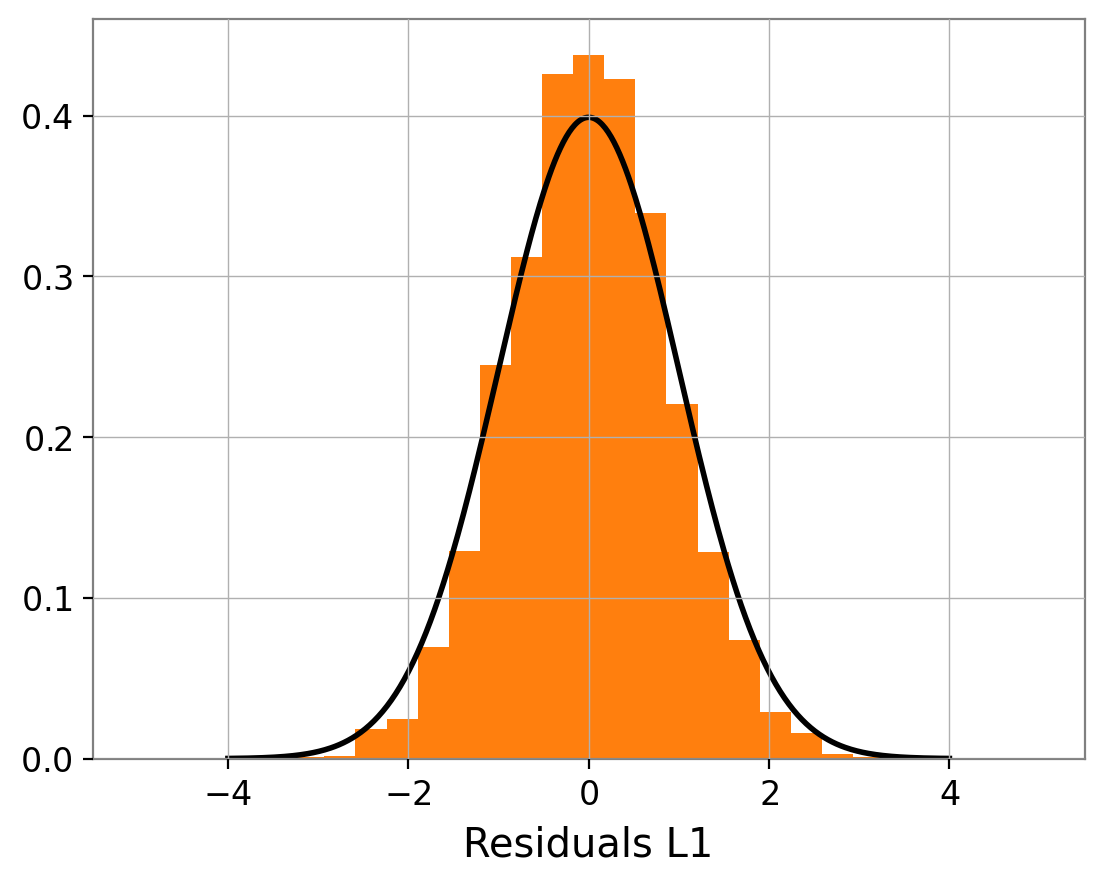

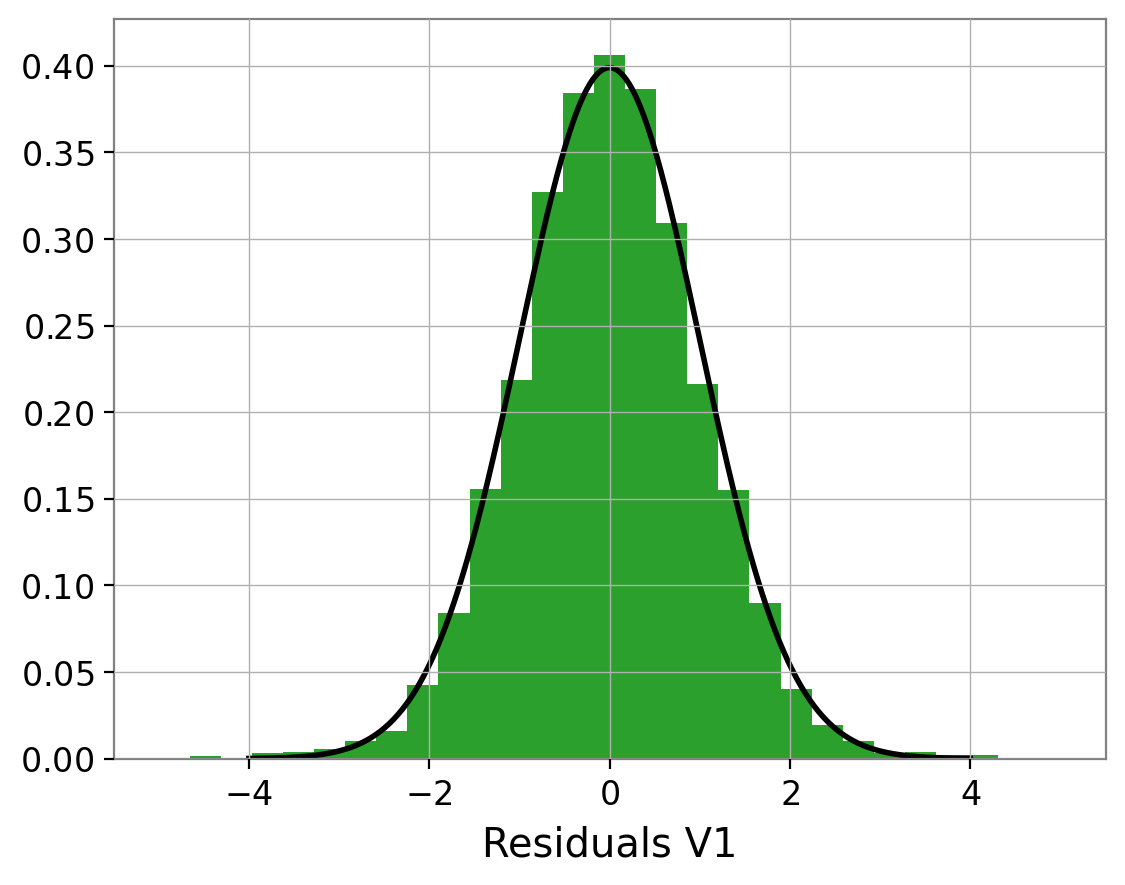

In [46]:
# Plot whitened
for i, ifo in enumerate(lm.ifos): 

    times = lm.time_dict[ifo]
    mask = (times > lm.reference_time-1) & (times < lm.reference_time+0.1)
    strain = lm.whitened_data_dict[ifo][mask]

    plt.figure()

    residuals = []
    for j in range(len(wfs_whitened)):
        wf =  wfs_whitened[j][ifo][mask]
        residuals.append( strain - wf )

    flt_res = np.asarray(residuals).flatten()
    plt.hist(flt_res, color=f'C{i}', bins=np.linspace(-5,5,30), density=True)

    plt.plot(x_values, pdf_values, color='k', lw=2)
    plt.xlabel(f'Residuals {ifo}')
    plt.show()